In [119]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import keras
from tensorflow.keras.layers import Dropout, LSTM, GRU, SimpleRNN, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt

import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore')

In [3]:
gsheet_url="https://docs.google.com/spreadsheets/d/1Sqf4OdzWkm_BkfnSw2YAMF_J7vEApKu3uJosyqNgPrE/edit#gid=0"
url = gsheet_url.replace('/edit#gid=', '/export?format=csv&gid=')
df = pd.read_csv(url)
df.head()

,Date,Open,High,Low,Close,Volume
0,8/16/2016 16:00:00,780.30,780.98,773.44,777.14,1028047
1,8/17/2016 16:00:00,777.32,780.81,773.53,779.91,924226
2,8/18/2016 16:00:00,780.01,782.86,777.00,777.50,719429
3,8/19/2016 16:00:00,775.00,777.10,773.13,775.42,861546
4,8/22/2016 16:00:00,773.27,774.54,770.05,772.15,951362


In [6]:
df['Date'] = pd.to_datetime(df['Date'])
df.head()

,Date,Open,High,Low,Close,Volume
0,2016-08-16 16:00:00,780.30,780.98,773.44,777.14,1028047
1,2016-08-17 16:00:00,777.32,780.81,773.53,779.91,924226
2,2016-08-18 16:00:00,780.01,782.86,777.00,777.50,719429
3,2016-08-19 16:00:00,775.00,777.10,773.13,775.42,861546
4,2016-08-22 16:00:00,773.27,774.54,770.05,772.15,951362


In [11]:
df['Date'] = pd.to_datetime(df.Date.dt.strftime('%Y/%m/%d'))
df.head()

,Date,Open,High,Low,Close,Volume
0,2016-08-16,780.30,780.98,773.44,777.14,1028047
1,2016-08-17,777.32,780.81,773.53,779.91,924226
2,2016-08-18,780.01,782.86,777.00,777.50,719429
3,2016-08-19,775.00,777.10,773.13,775.42,861546
4,2016-08-22,773.27,774.54,770.05,772.15,951362


In [13]:
df = df.set_index('Date')
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2016-08-16,780.30,780.98,773.44,777.14,1028047
2016-08-17,777.32,780.81,773.53,779.91,924226
2016-08-18,780.01,782.86,777.00,777.50,719429
2016-08-19,775.00,777.10,773.13,775.42,861546
2016-08-22,773.27,774.54,770.05,772.15,951362


In [14]:
# Drop all other columns except High
df.drop(columns=['Open', 'Low', 'Close', 'Volume'], inplace=True)
df.head()

,High
Date,
2016-08-16,780.98
2016-08-17,780.81
2016-08-18,782.86
2016-08-19,777.10
2016-08-22,774.54


In [16]:
df.resample('Y').std()

,High
Date,
2016-12-31,13.377985
2017-12-31,78.340330
2018-12-31,64.329414
2019-12-31,81.109499
2020-12-31,174.859537
2021-12-31,368.023070
2022-12-31,115.879269


In [171]:
train_df = df[df.index.year < 2020]
test_df = df[df.index.year >=2020]

print(f'Shape of train_df {train_df.shape}')
print(f'Shape of test_df {test_df.shape}')

Shape of train_df (850, 1)
Shape of test_df (529, 1)


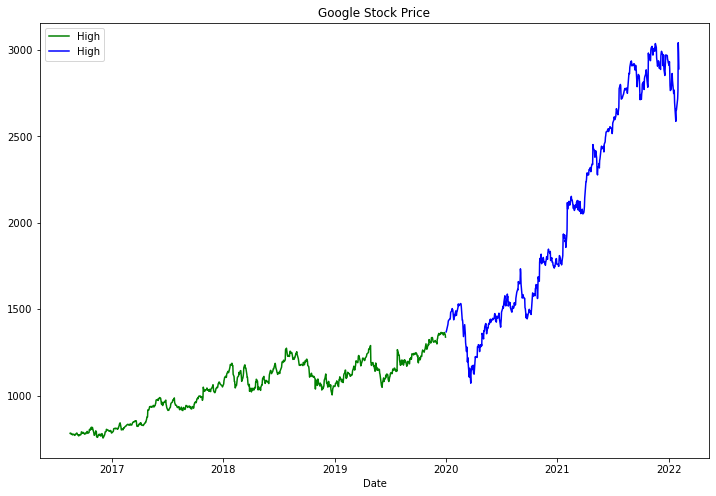

In [172]:
# plot train and test dataframes in different colors

plt.figure(figsize=(12,8))
#plt.lin(train_df)
sns.lineplot(data=train_df, palette=['g'])
sns.lineplot(data=test_df, palette=['b'])
plt.title('Google Stock Price')
plt.show()

In [173]:
def rmse_return(actual, predicted):
    return np.sqrt(mean_squared_error(actual, predicted))

In [174]:
# rmse_return test

print(rmse_return([1,2,3,4,5], [2,4,6,8,10]))

3.3166247903554


In [175]:
mmc = MinMaxScaler(feature_range=(0,1))
train_df['Scaled'] = mmc.fit_transform(train_df)

In [176]:
train_df.head()

,High,Scaled
Date,,
2016-08-16,780.98,0.044157
2016-08-17,780.81,0.043879
2016-08-18,782.86,0.047234
2016-08-19,777.10,0.037807
2016-08-22,774.54,0.033617


In [202]:
# Extract X_train, y_train

def get_X_Y_data(df, n_days=60):
    X_train = []
    y_train = []

    index = 0
    df_length = len(df)
    while index < df_length - n_days:
        X = np.asarray(df[index: n_days+index])
        y = df.iloc[n_days+index]
        X_train.append(X)
        y_train.append(y)
        index+=1
        
    return np.asarray(X_train), np.array(y_train)

In [203]:
X_train, y_train = get_X_Y_data(train_df[['Scaled']])

In [204]:
print(X_train.shape)
print(y_train.shape)

(790, 60, 1)
(790, 1)


In [214]:
y_train

array([[0.0609329 ],
       [0.0608347 ],
       [0.01109656],
       [0.00630115],
       [0.01705401],
       [0.02022913],
       [0.03060556],
       [0.03436989],
       [0.02569558],
       [0.03757774],
       [0.02337152],
       [0.01800327],
       [0.04178396],
       [0.0400982 ],
       [0.0310802 ],
       [0.00957447],
       [0.        ],
       [0.01620295],
       [0.02427169],
       [0.02841244],
       [0.03957447],
       [0.05798691],
       [0.06096563],
       [0.08245499],
       [0.08183306],
       [0.0801964 ],
       [0.07669394],
       [0.07145663],
       [0.07307692],
       [0.0698527 ],
       [0.06435352],
       [0.06340426],
       [0.07178396],
       [0.06584288],
       [0.05225859],
       [0.04710311],
       [0.05831424],
       [0.06111293],
       [0.06625205],
       [0.08821604],
       [0.09160393],
       [0.09022913],
       [0.0886252 ],
       [0.08738134],
       [0.09364975],
       [0.08697218],
       [0.08545008],
       [0.090

In [198]:
X_train = np.reshape(X_train, (X_train.shape[1], X_train.shape[0], 1))

In [220]:
model = Sequential()

model.add(SimpleRNN(100, return_sequences=True, input_shape = (X_train.shape[1], 1), activation='tanh'))
model.add(Dropout(0.2))

model.add(SimpleRNN(100, return_sequences=True, input_shape = (X_train.shape[1], 1), activation='tanh'))
model.add(Dropout(0.2))

model.add(GRU(100, return_sequences=True, input_shape = (X_train.shape[1], 1), activation='tanh'))
model.add(Dropout(0.2))

model.add(GRU(100, activation='tanh'))
model.add(Dropout(0.2))

model.add(Dense(units=1))

In [221]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_21 (SimpleRNN)    (None, 60, 100)           10200     
_________________________________________________________________
dropout_38 (Dropout)         (None, 60, 100)           0         
_________________________________________________________________
simple_rnn_22 (SimpleRNN)    (None, 60, 100)           20100     
_________________________________________________________________
dropout_39 (Dropout)         (None, 60, 100)           0         
_________________________________________________________________
gru_17 (GRU)                 (None, 60, 100)           60600     
_________________________________________________________________
dropout_40 (Dropout)         (None, 60, 100)           0         
_________________________________________________________________
gru_18 (GRU)                 (None, 100)             

In [222]:
# Compiling the GRU
model.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
# Fitting to the training set
model.fit(X_train,y_train,epochs=50,batch_size=150)

Epoch 1/50
6/6 [==============================] - 8s 247ms/step - loss: 0.1540
Epoch 2/50
6/6 [==============================] - 2s 249ms/step - loss: 0.0682
Epoch 3/50
6/6 [==============================] - 2s 246ms/step - loss: 0.0759
Epoch 4/50
6/6 [==============================] - 2s 248ms/step - loss: 0.0402
Epoch 5/50
6/6 [==============================] - 2s 257ms/step - loss: 0.0256
Epoch 6/50
6/6 [==============================] - 2s 260ms/step - loss: 0.0199
Epoch 7/50
6/6 [==============================] - 2s 248ms/step - loss: 0.0139
Epoch 8/50
6/6 [==============================] - 2s 250ms/step - loss: 0.0102
Epoch 9/50
6/6 [==============================] - 2s 250ms/step - loss: 0.0105
Epoch 10/50
6/6 [==============================] - 2s 266ms/step - loss: 0.0092
Epoch 11/50
6/6 [==============================] - 2s 277ms/step - loss: 0.0084
Epoch 12/50
6/6 [==============================] - 2s 282ms/step - loss: 0.0090
Epoch 13/50
6/6 [==============================] 

In [283]:
model = Sequential()

model.add(LSTM(100, return_sequences=True, input_shape = (X_train.shape[1], 1), activation='tanh'))
model.add(Dropout(0.2))

model.add(LSTM(100, return_sequences=True, input_shape = (X_train.shape[1], 1), activation='tanh'))
model.add(Dropout(0.2))

model.add(LSTM(100, return_sequences=True, input_shape = (X_train.shape[1], 1), activation='tanh'))
model.add(Dropout(0.2))

model.add(LSTM(100, activation='tanh'))
model.add(Dropout(0.2))

model.add(Dense(units=1))

In [284]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 100)           40800     
_________________________________________________________________
dropout_42 (Dropout)         (None, 60, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 100)           80400     
_________________________________________________________________
dropout_43 (Dropout)         (None, 60, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 100)           80400     
_________________________________________________________________
dropout_44 (Dropout)         (None, 60, 100)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)             

In [285]:
# Compiling the GRU
model.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
# Fitting to the training set
model.fit(X_train,y_train,epochs=50,batch_size=150)

Epoch 1/50
6/6 [==============================] - 13s 406ms/step - loss: 0.1540
Epoch 2/50
6/6 [==============================] - 3s 414ms/step - loss: 0.1097
Epoch 3/50
6/6 [==============================] - 3s 412ms/step - loss: 0.0572
Epoch 4/50
6/6 [==============================] - 2s 404ms/step - loss: 0.0580
Epoch 5/50
6/6 [==============================] - 3s 409ms/step - loss: 0.0478
Epoch 6/50
6/6 [==============================] - 3s 437ms/step - loss: 0.0376
Epoch 7/50
6/6 [==============================] - 3s 416ms/step - loss: 0.0328
Epoch 8/50
6/6 [==============================] - 3s 423ms/step - loss: 0.0225
Epoch 9/50
6/6 [==============================] - 3s 470ms/step - loss: 0.0149
Epoch 10/50
6/6 [==============================] - 3s 494ms/step - loss: 0.0085
Epoch 11/50
6/6 [==============================] - 3s 465ms/step - loss: 0.0065
Epoch 12/50
6/6 [==============================] - 3s 504ms/step - loss: 0.0072
Epoch 13/50
6/6 [==============================]

In [286]:
test_df['Scaled'] = mmc.transform(test_df)
X_test, y_test = get_X_Y_data(train_df[-60:][['Scaled']].append(test_df[['Scaled']]))

In [287]:
X_test.shape, y_test.shape

((529, 60, 1), (529, 1))

In [288]:
y_pred = model.predict(X_test)
y_pred = mmc.inverse_transform(y_pred)

In [289]:
rmse_return(mmc.inverse_transform(y_test), y_pred)

622.7544976706937

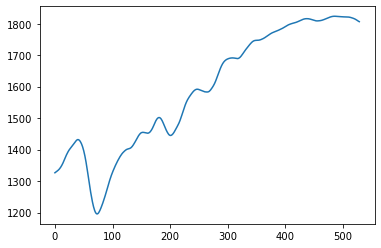

In [290]:
plt.plot(y_pred.reshape(1,-1)[0])
plt.show()

In [291]:
y_pred.reshape(1,-1)[0].shape

(529,)

In [292]:
pred_df = test_df.copy()
pred_df['High'] = y_pred.reshape(1,-1)[0]

In [293]:
pred_df.head()

,High,Scaled
Date,,
2020-01-02,1326.443726,1.005139
2020-01-03,1327.958984,1.012275
2020-01-06,1329.357178,1.051555
2020-01-07,1330.697998,1.062177
2020-01-08,1332.053955,1.076236


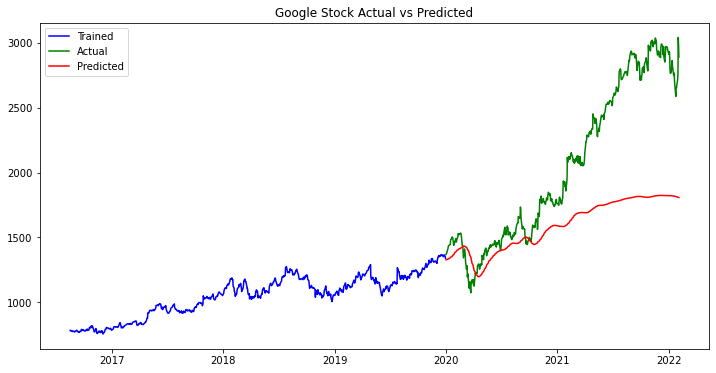

In [294]:
# We have chosen 'High' attribute for prices. Let's see what it looks like
plt.figure(figsize=(12,6))
plt.plot(df[df.index.year < 2020]['High'], c='b')
plt.plot(df[df.index.year >= 2020]['High'], c='g')
plt.plot(pred_df['High'], c='r')
plt.legend(['Trained', 'Actual', 'Predicted'])
plt.title('Google Stock Actual vs Predicted')
plt.show()